# `dtreeviz` scikit-learn Examples

([View this notebook in Colab](https://colab.research.google.com/github/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_visualisations.ipynb))

The [dtreeviz](https://github.com/parrt/dtreeviz) library is designed to help machine learning practitioners visualize and interpret decision trees and decision-tree-based models, such as gradient boosting machines.  

The purpose of this notebook is to illustrate the main capabilities and functions of the dtreeviz API. To do that, we will use scikit-learn and the toy but well-known Titanic data set for illustrative purposes.  Currently, dtreeviz supports the following decision tree libraries:

* [scikit-learn](https://scikit-learn.org/stable)
* [XGBoost](https://xgboost.readthedocs.io/en/latest)
* [Spark MLlib](https://spark.apache.org/mllib/)
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
* [Tensorflow](https://www.tensorflow.org/decision_forests)

To interopt with these different libraries, dtreeviz uses an adaptor object, obtained from function `dtreeviz.model()`, to extract model information necessary for visualization. Given such an adaptor object, all of the dtreeviz functionality is available to you using the same programmer interface. The basic dtreeviz usage recipe is:

1. Import dtreeviz and your decision tree library
2. Acquire and load data into memory
3. Train a classifier or regressor model using your decision tree library
4. Obtain a dtreeviz adaptor model using<br>`viz_model = dtreeviz.model(your_trained_model,...)`
5. Call dtreeviz functions, such as<br>`viz_model.view()` or `viz_model.explain_prediction_path(sample_x)`

The four categories of dtreeviz functionality are:

1. Tree visualizations
2. Prediction path explanations
3. Leaf information
4. Feature space exploration

We have grouped code examples by [classifiers](#Classifiers) and [regressors](#Regressors), with a follow up section on [partitioning feature space](#Feature-Space-Partitioning).

*These examples require dtreeviz 2.0 or above because the code uses the new API introduced in 2.0.*

## Setup

In [1]:
import sys
import os

In [2]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import dtreeviz

random_state = 1234 # get reproducible trees

## Load Sample Data

In [4]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv"
dataset = pd.read_csv(dataset_url)
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

# Classifiers

To demonstrate classifier decision trees, we trying to model using six features to predict the boolean survived target.

In [5]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=random_state)
tree_classifier.fit(dataset[features].values, dataset[target].values)

DecisionTreeClassifier(max_depth=3, random_state=1234)

## Initialize dtreeviz model (adaptor)

To adapt dtreeviz to a specific model, use the `model()` function to get an adaptor.  You'll need to provide the model, X/y data, feature names, target name, and target class names:

In [6]:
viz_model = dtreeviz.model(tree_classifier,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["survive", "perish"])

We'll use this model to demonstrate dtreeviz functionality in the following sections; the code will look the same for any decision tree library once we have this model adaptor.

## Tree structure visualizations

To show the decision tree structure using the default visualization, call `view()`:

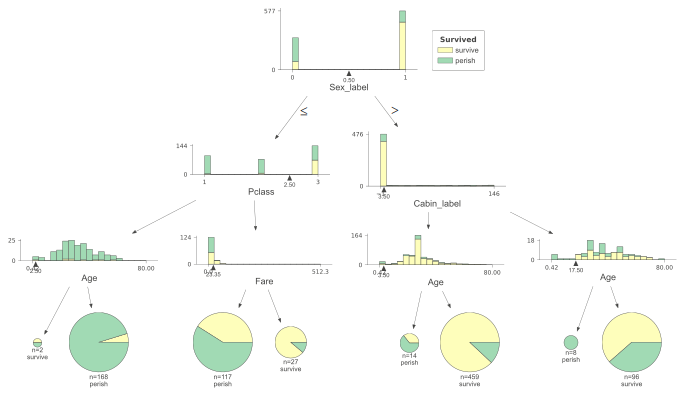

In [7]:
viz_model.view()

To change the visualization, you can pass parameters, such as changing the orientation to left-to-right:

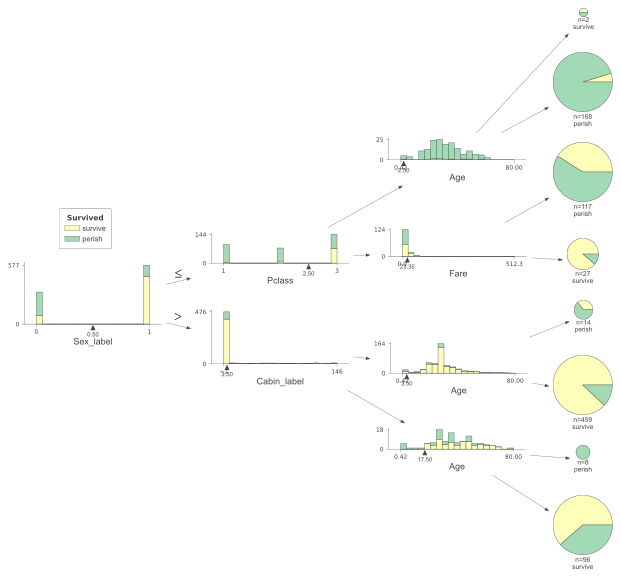

In [8]:
viz_model.view(orientation="LR")

To visualize larger trees, you can reduce the amount of detail by turning off the fancy view:

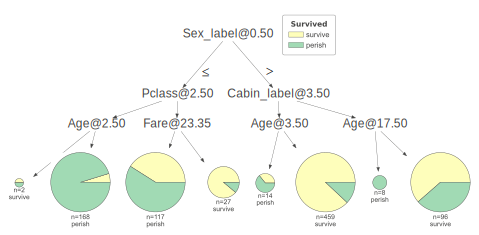

In [9]:
viz_model.view(fancy=False)

Another way to reduce the visualization size is to specify the tree depths of interest:

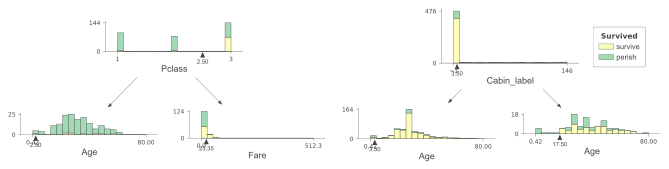

In [10]:
viz_model.view(depth_range_to_display=(1, 2)) # root is level 0

## Prediction path explanations

For interpretation purposes, we often want to understand how a tree behaves for a specific instance. Let's pick a specific instance:

In [11]:
x = dataset[features].iloc[10]
x

Pclass              3.0
Age                 4.0
Fare               16.7
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Name: 10, dtype: float64

and then display the path through the tree structure:

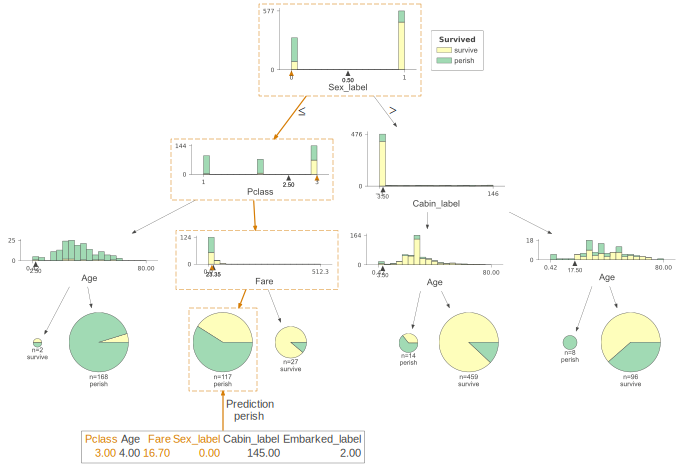

In [12]:
viz_model.view(x=x)

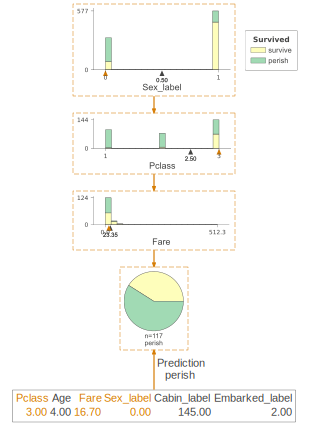

In [13]:
viz_model.view(x=x, show_just_path=True)

You can also get a string representation explaining the comparisons made as an instance is run down the tree:

In [14]:
print(viz_model.explain_prediction_path(x))

2.5 <= Pclass 
Fare < 23.35
Sex_label < 0.5



If you'd like the feature importance for a specific instance, as calculated by the underlying decision tree library, use `instance_feature_importance()`:

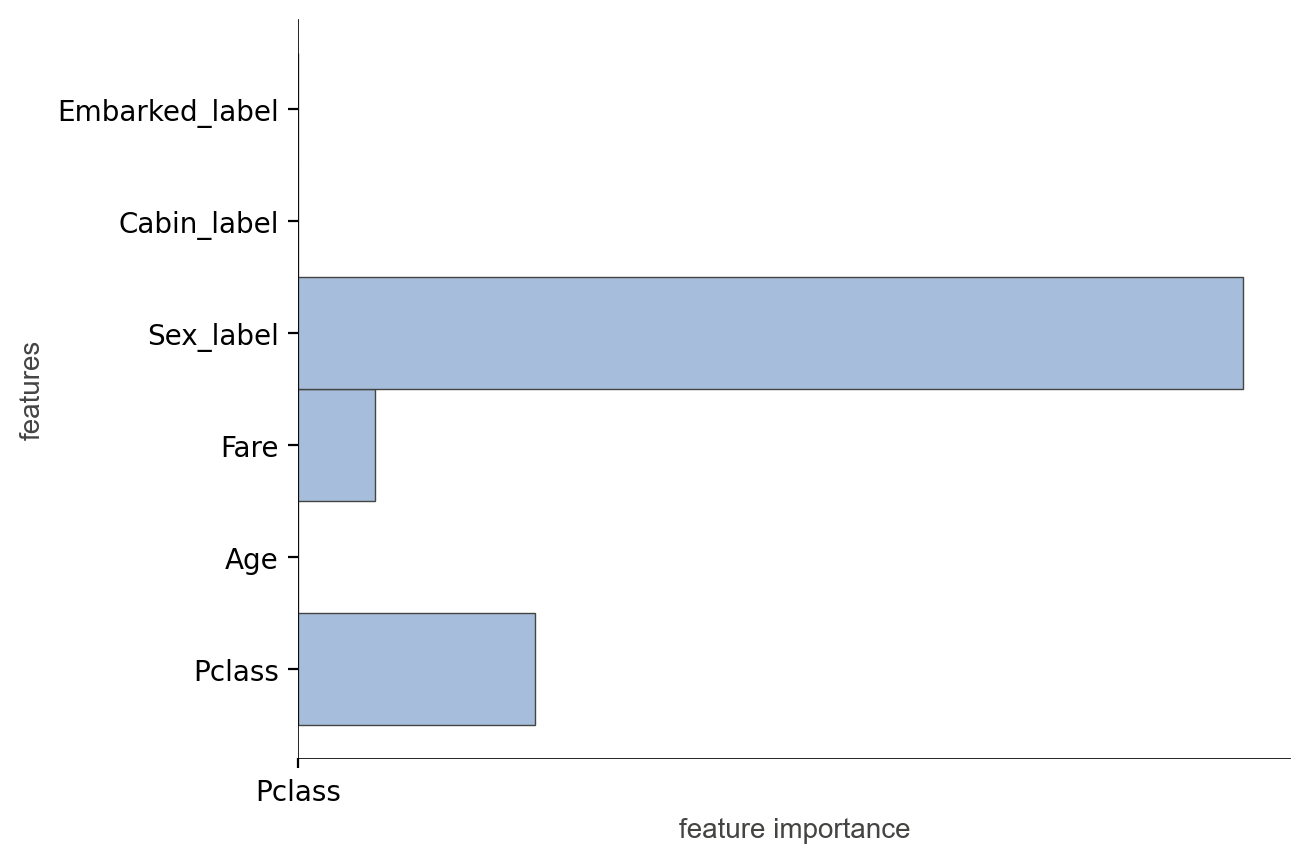

In [15]:
viz_model.instance_feature_importance(x)

## Leaf info

There are a number of functions to get information about the leaves of the tree.

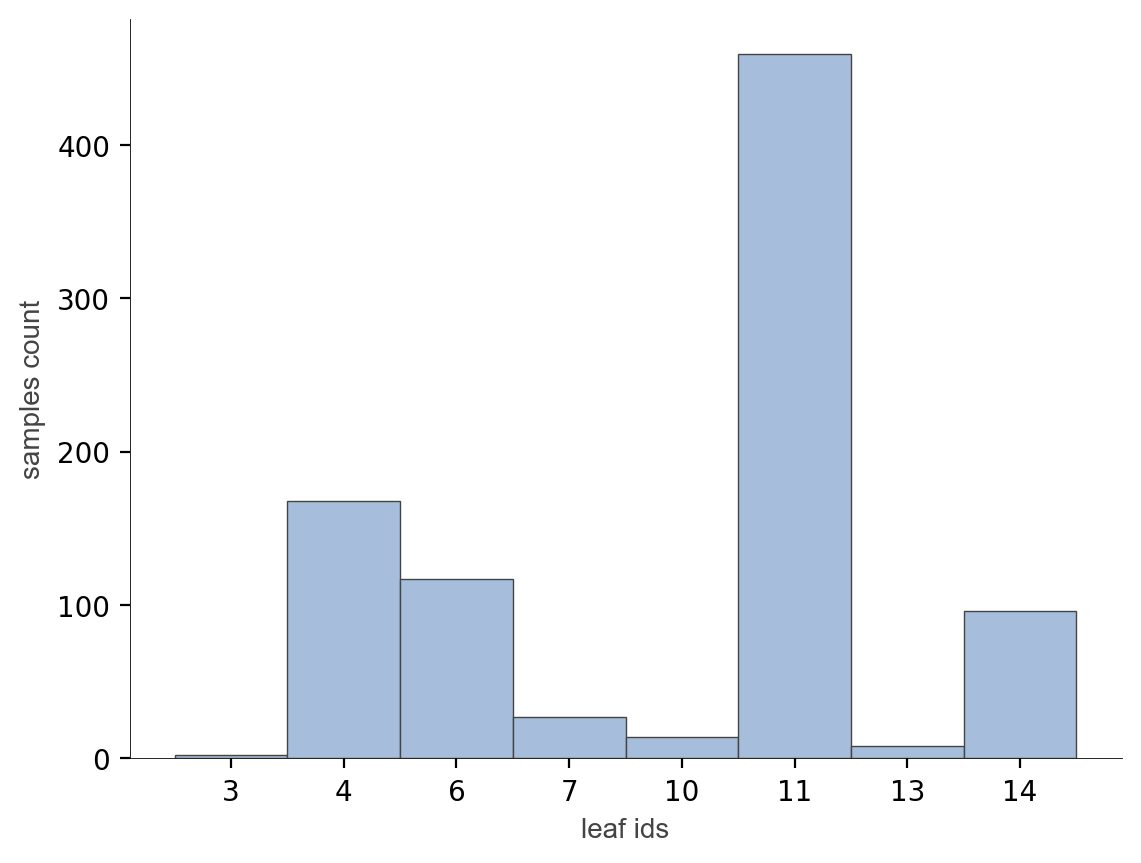

In [16]:
viz_model.leaf_sizes()

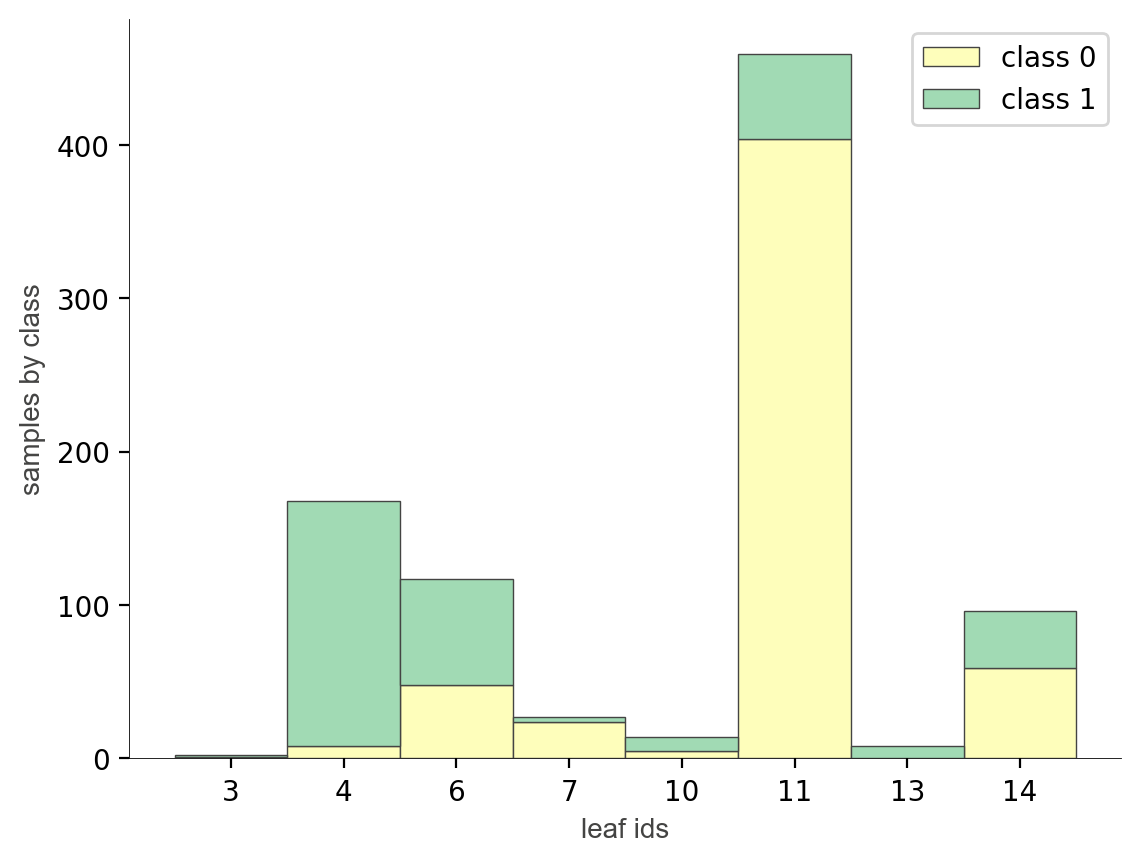

In [17]:
viz_model.ctree_leaf_distributions()

In [18]:
viz_model.node_stats(node_id=6)

Pclass         Age        Fare  Sex_label  Cabin_label  Embarked_label
count   117.0  117.000000  117.000000      117.0   117.000000      117.000000
mean      3.0   23.976667   11.722829        0.0     6.196581        1.341880
std       0.0   10.534377    4.695136        0.0    31.167855        0.789614
min       3.0    0.750000    6.750000        0.0    -1.000000        0.000000
25%       3.0   18.000000    7.775000        0.0    -1.000000        1.000000
50%       3.0   27.000000    9.587500        0.0    -1.000000        2.000000
75%       3.0   29.699118   15.500000        0.0    -1.000000        2.000000
max       3.0   63.000000   23.250000        0.0   145.000000        2.000000

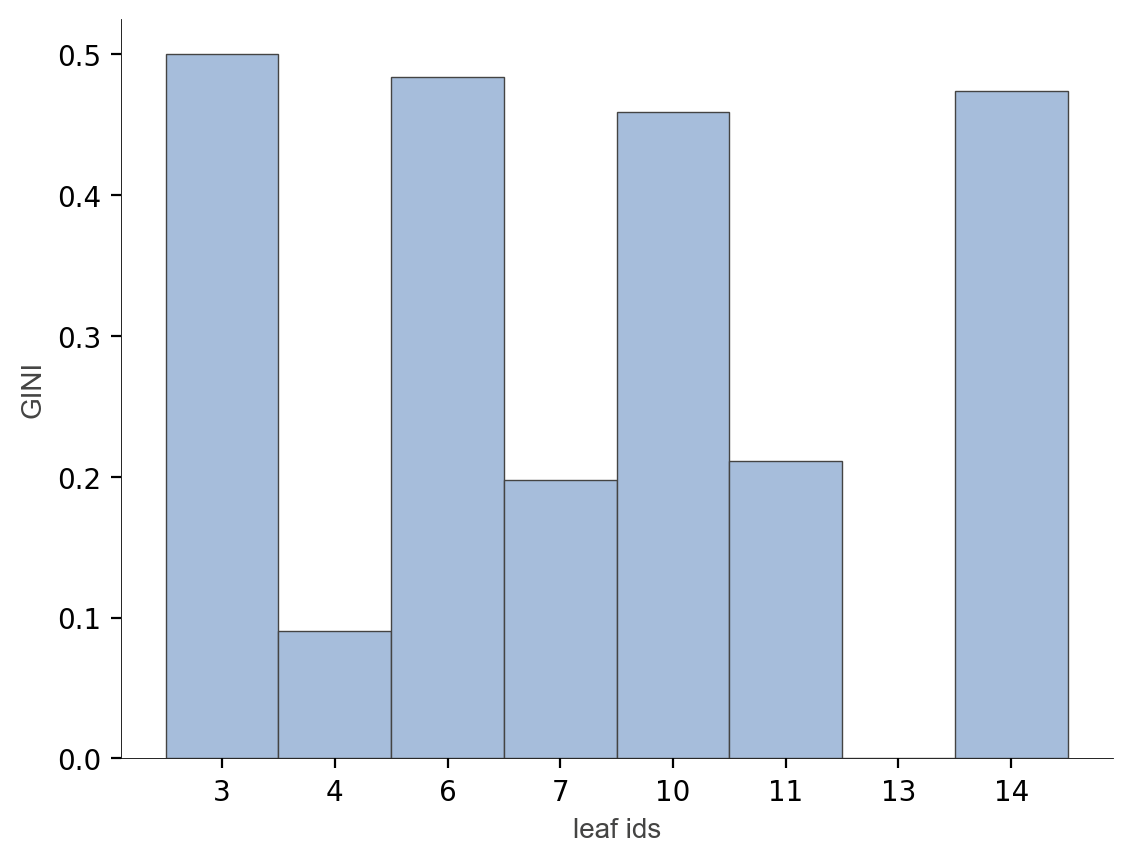

In [19]:
viz_model.leaf_purity()

# Regressors

To demonstrate regressor tree visualization, we start by creating a regressors model that predicts age instead of survival:

In [20]:
features_reg = ["Pclass", "Fare", "Sex_label", "Cabin_label", "Embarked_label", "Survived"]
target_reg = "Age"

tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=random_state, criterion="absolute_error")
tree_regressor.fit(dataset[features_reg].values, dataset[target_reg].values)

DecisionTreeRegressor(criterion='absolute_error', max_depth=3,
                      random_state=1234)

## Initialize dtreeviz model (adaptor)

In [21]:
viz_rmodel = dtreeviz.model(model=tree_regressor, 
                            X_train=dataset[features_reg], 
                            y_train=dataset[target_reg], 
                            feature_names=features_reg, 
                            target_name=target_reg)

## Tree structure visualisations

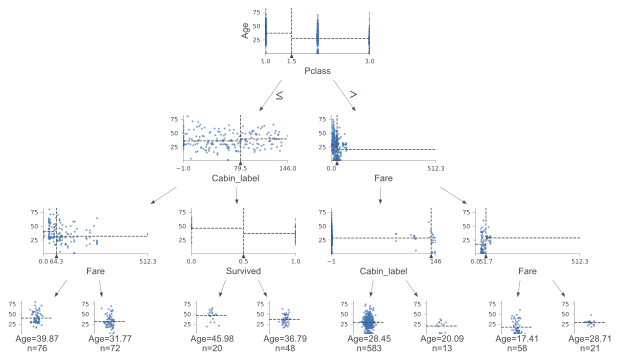

In [22]:
viz_rmodel.view()

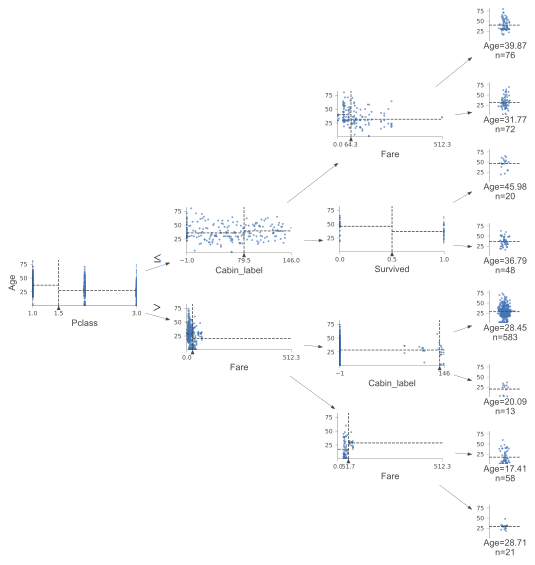

In [23]:
viz_rmodel.view(orientation="LR")

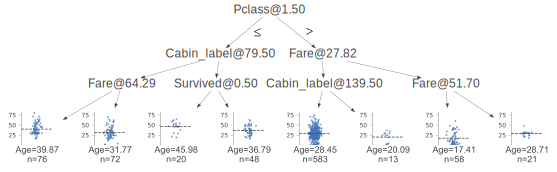

In [24]:
viz_rmodel.view(fancy=False)

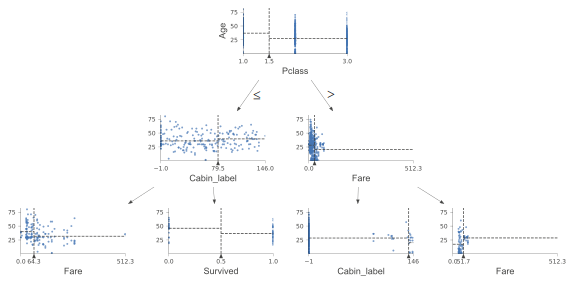

In [25]:
viz_rmodel.view(depth_range_to_display=(0, 2))

## Prediction path explanations

In [26]:
x = dataset[features_reg].iloc[10]
x

Pclass              3.0
Fare               16.7
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Survived            1.0
Name: 10, dtype: float64

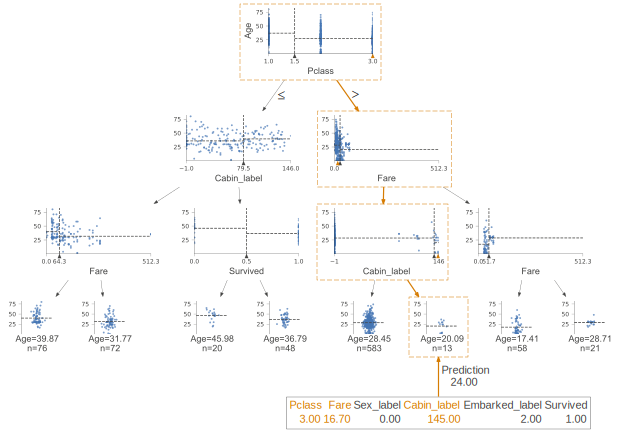

In [27]:
viz_rmodel.view(x = x)

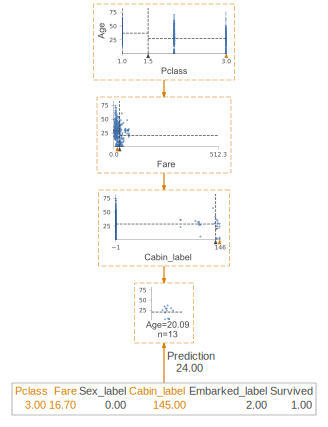

In [28]:
viz_rmodel.view(show_just_path=True, x = x)

In [29]:
print(viz_rmodel.explain_prediction_path(x))

1.5 <= Pclass 
Fare < 27.82
139.5 <= Cabin_label 



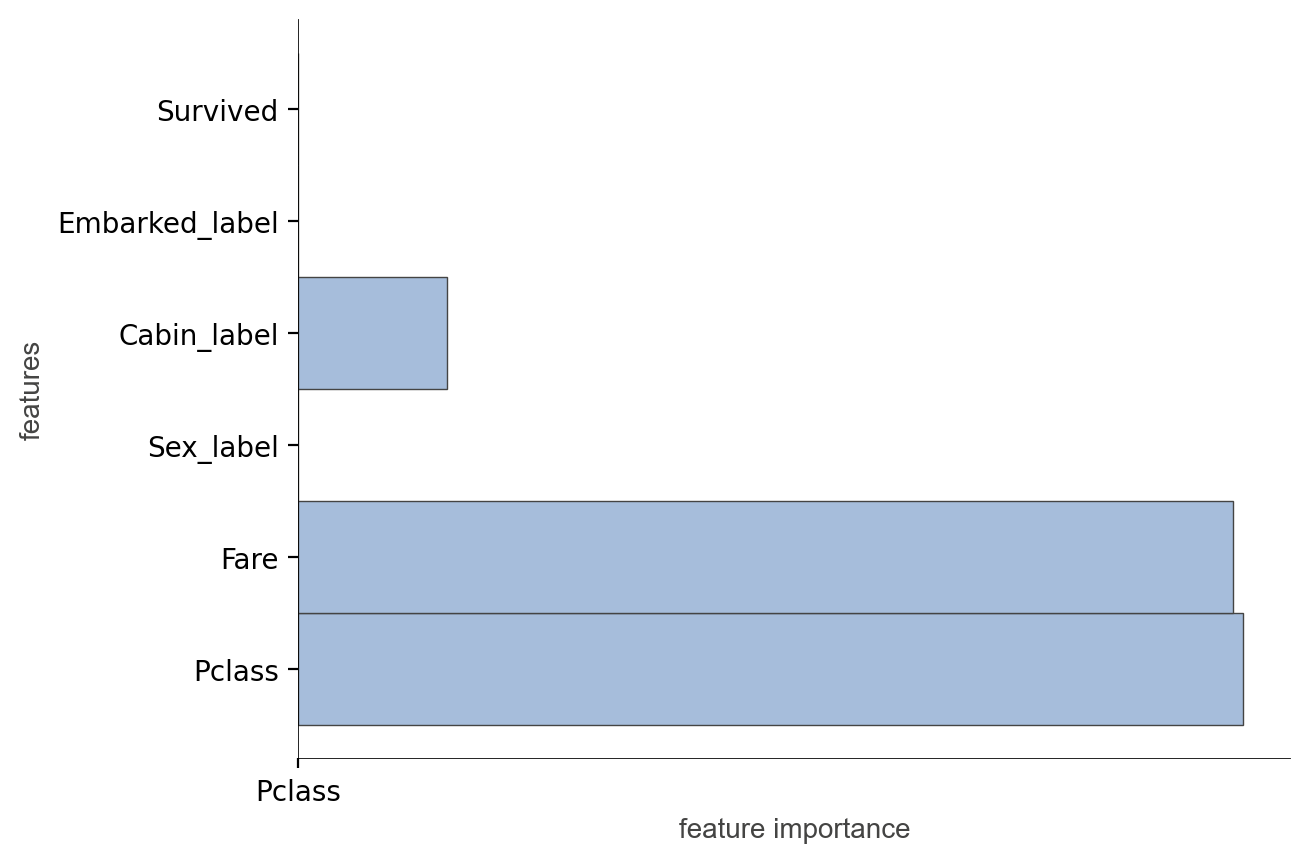

In [30]:
viz_rmodel.instance_feature_importance(x)

## Leaf info

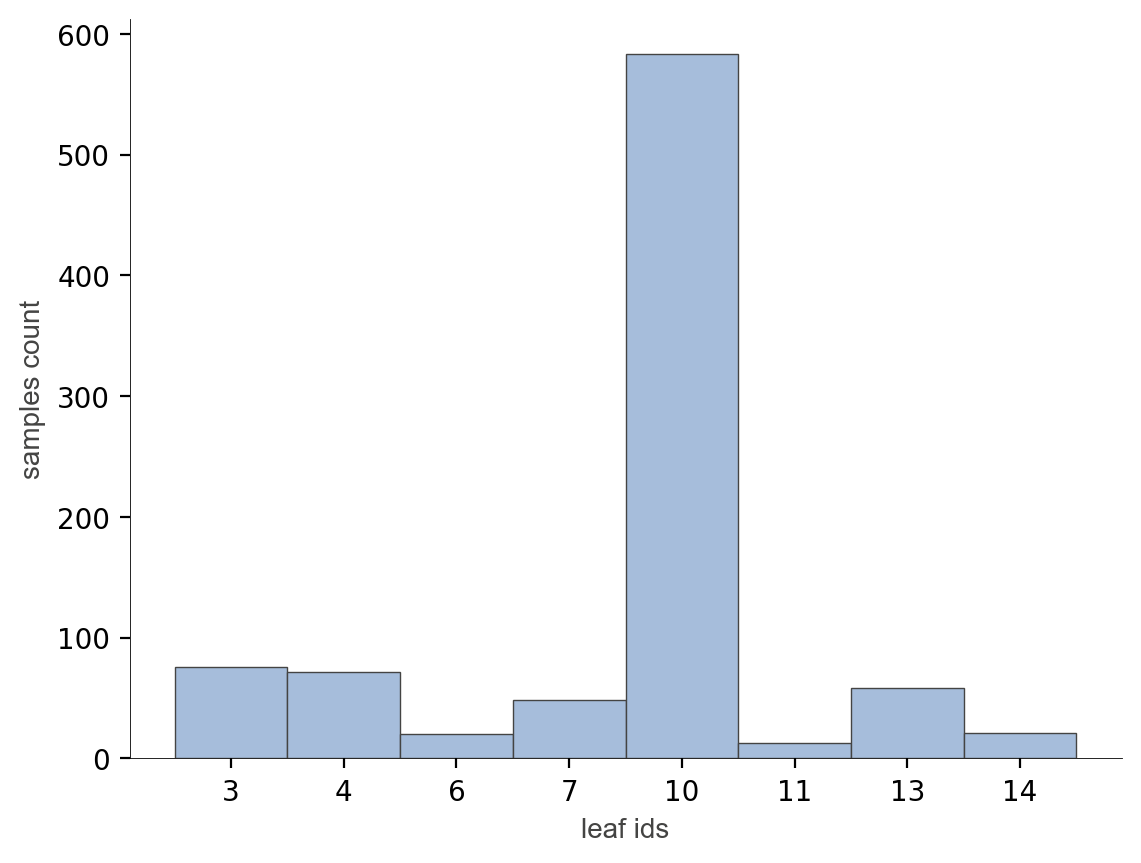

In [31]:
viz_rmodel.leaf_sizes()

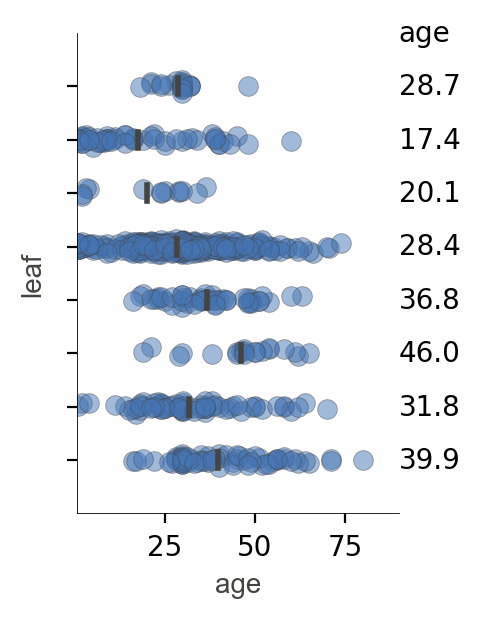

In [32]:
viz_rmodel.rtree_leaf_distributions()

In [33]:
viz_rmodel.node_stats(node_id=4)

Pclass        Fare  Sex_label  Cabin_label  Embarked_label   Survived
count    72.0   72.000000  72.000000    72.000000       72.000000  72.000000
mean      1.0  152.167936   0.347222    39.250000        0.916667   0.763889
std       0.0   97.808005   0.479428    26.556742        1.031203   0.427672
min       1.0   66.600000   0.000000    -1.000000       -1.000000   0.000000
25%       1.0   83.158300   0.000000    20.750000        0.000000   1.000000
50%       1.0  120.000000   0.000000    40.000000        0.000000   1.000000
75%       1.0  211.337500   1.000000    63.000000        2.000000   1.000000
max       1.0  512.329200   1.000000    79.000000        2.000000   1.000000

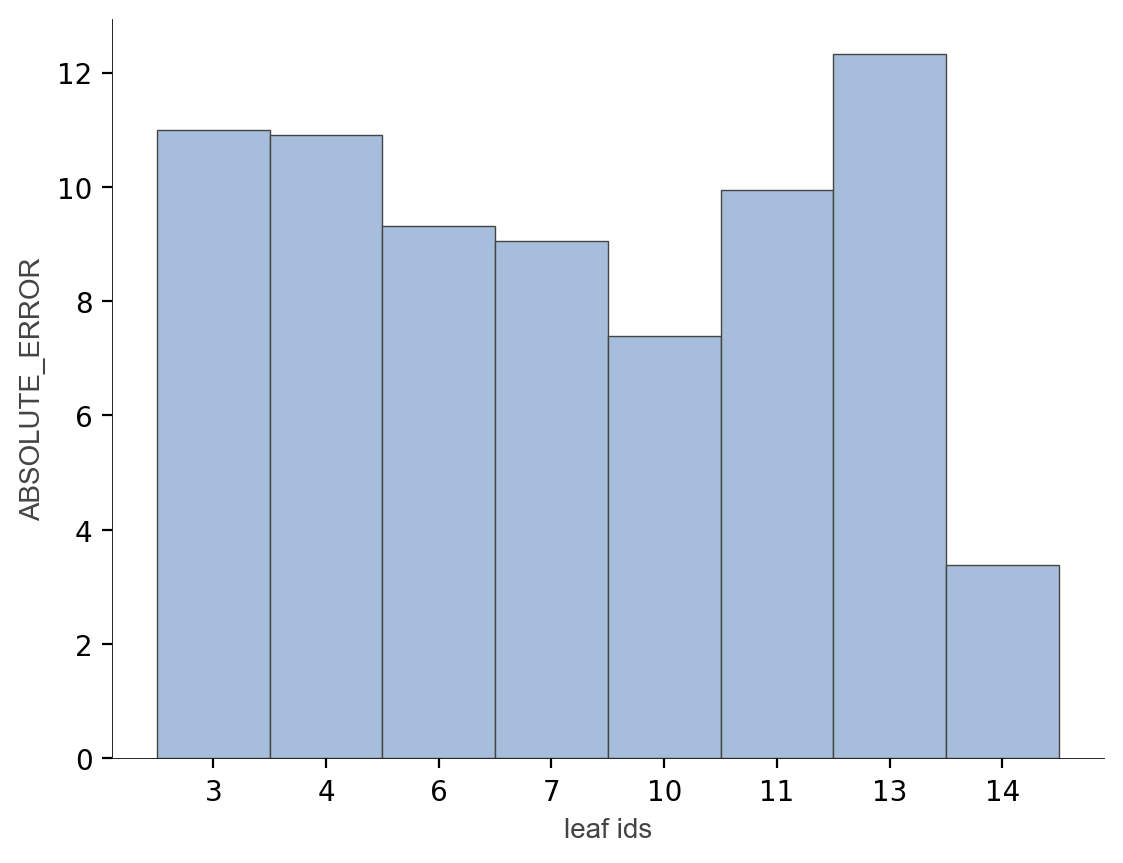

In [34]:
viz_rmodel.leaf_purity()

# Feature Space Partitioning

Decision trees partition feature space in such a way as to maximize target value purity for the instances associated with a node. It's often useful to visualize the feature space partitioning, although it's not feasible to visualize more than a couple of dimensions.

## Classification

To visualize how it decision tree partitions a single feature, let's train a shallow decision tree classifier using the toy Iris data.

In [35]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
class_names = iris.target_names

X = X[:,2].reshape(-1,1) # petal length (cm)
y = iris.target

In [36]:
dtc_univar = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1)
dtc_univar.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [37]:
viz_model = dtreeviz.model(dtc_univar,
                           X_train=X, y_train=y,
                           feature_names=['petal length (cm)'],
                           target_name='iris',
                           class_names=class_names)

The following diagram indicates that the decision tree splits the petal length feature into three mostly-pure regions:

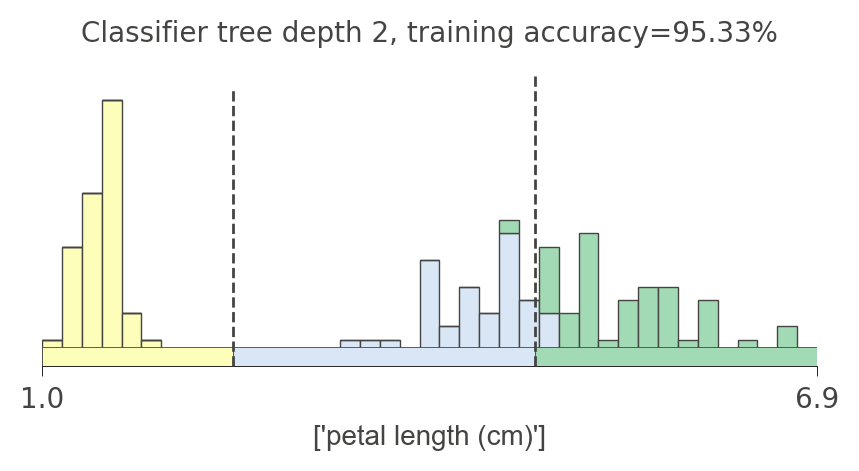

In [38]:
viz_model.ctree_feature_space(nbins=40, gtype='barstacked', show={'splits','title'},
                             figsize=(5,2))

A deeper tree gives this finer grand partitioning of the single feature space:

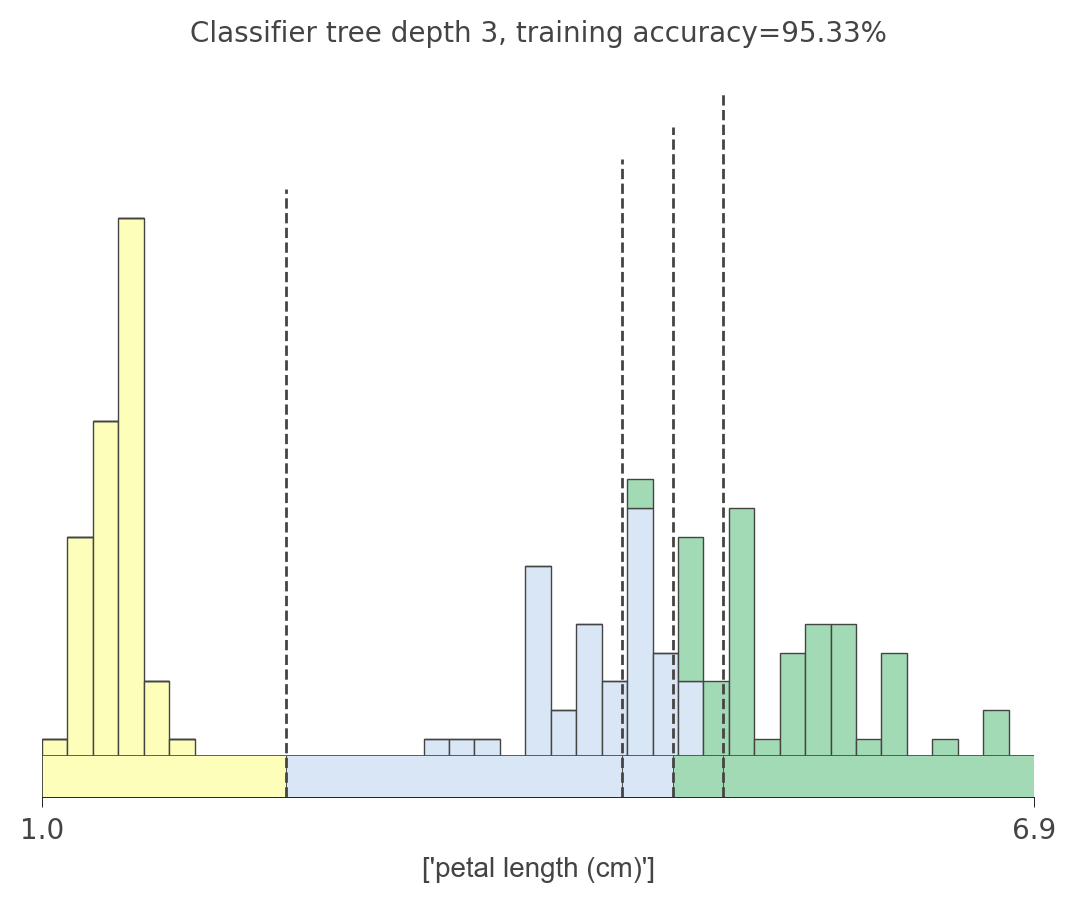

In [39]:
dtc_univar = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
dtc_univar.fit(X, y)

viz_model = dtreeviz.model(dtc_univar,
                           X_train=X, y_train=y,
                           feature_names=['petal length (cm)'],
                           target_name='iris',
                           class_names=class_names)

viz_model.ctree_feature_space(nbins=40, gtype='barstacked', show={'splits','title'})

Let's look at how a decision tree partitions two-dimensional feature space.

In [40]:
X = iris.data
X = X[:,[0,3]] # 'sepal length (cm)', 'petal width (cm)'
y = iris.target
dtc_bivar = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
dtc_bivar.fit(X, y)

DecisionTreeClassifier(max_depth=3)

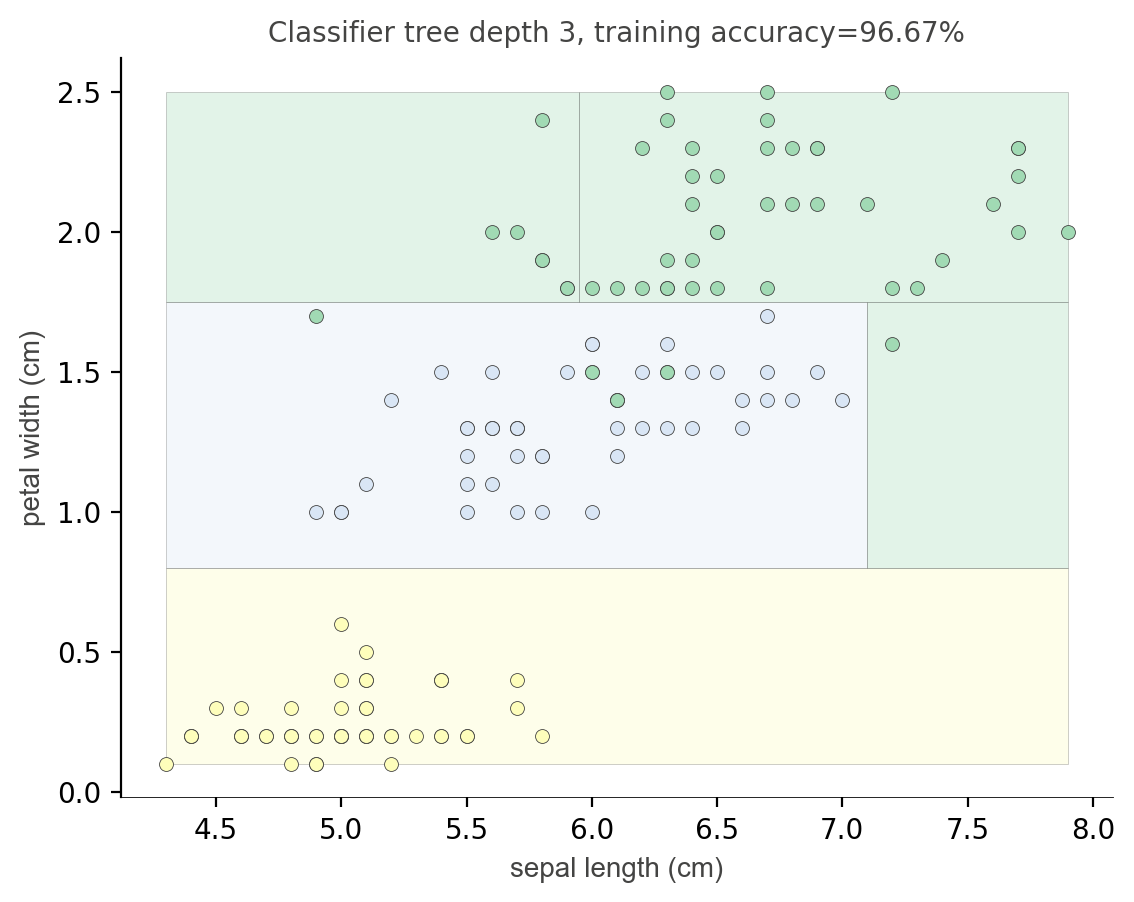

In [41]:
viz_model = dtreeviz.model(dtc_bivar,
                           X_train=X, y_train=y,
                           feature_names=['sepal length (cm)', 'petal width (cm)'], 
                           target_name='iris',
                           class_names=class_names)

viz_model.ctree_feature_space(nbins=40, gtype='barstacked', show={'splits','title'})

## Regression

To demonstrate regression, let's load a toy Cars data set and visualize the partitioning of univariate and bivariate feature spaces.

In [42]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/cars.csv"
df_cars = pd.read_csv(dataset_url)
X = df_cars[['WGT']]
y = df_cars['MPG']

In [43]:
dtr_univar = DecisionTreeRegressor(max_depth=3, criterion="absolute_error")
dtr_univar.fit(X.values, y.values)

DecisionTreeRegressor(criterion='absolute_error', max_depth=3)

In [44]:
viz_rmodel = dtreeviz.model(dtr_univar, X, y,
                           feature_names=['WGT'],
                           target_name='MPG')

The following visualization illustrates how the decision tree breaks up the `WGT` (car weight) in order to get relatively pure `MPG` (miles per gallon) target values.

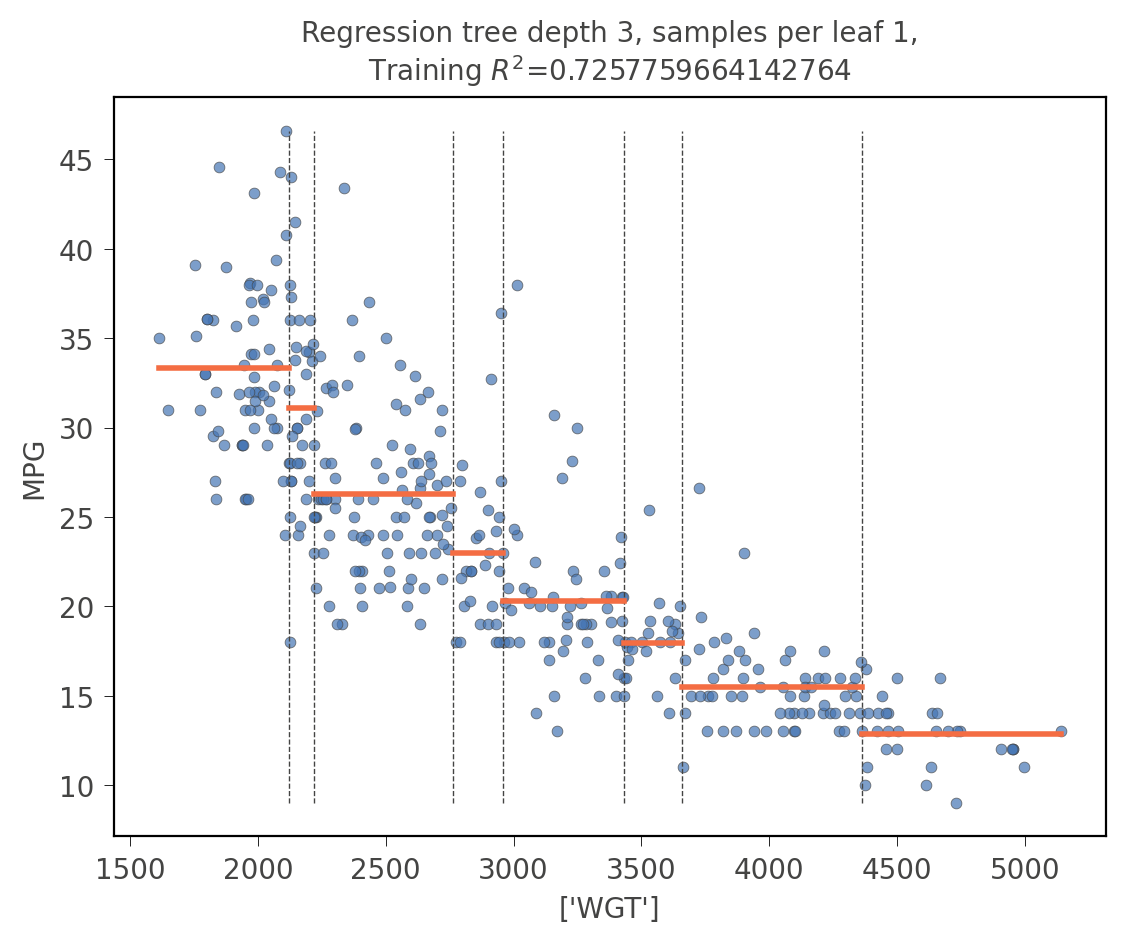

In [45]:
viz_rmodel.rtree_feature_space()

In order to visualize two-dimensional feature space, we can draw in three dimensions.

In [46]:
X = df_cars[["WGT", "ENG"]]
y = df_cars['MPG']
dtr_bivar_3d = DecisionTreeRegressor(max_depth=3, criterion="absolute_error")
dtr_bivar_3d.fit(X.values, y.values)

DecisionTreeRegressor(criterion='absolute_error', max_depth=3)

In [47]:
viz_rmodel = dtreeviz.model(dtr_bivar_3d, X, y,
                           feature_names=["WGT", "ENG"],
                           target_name='MPG')

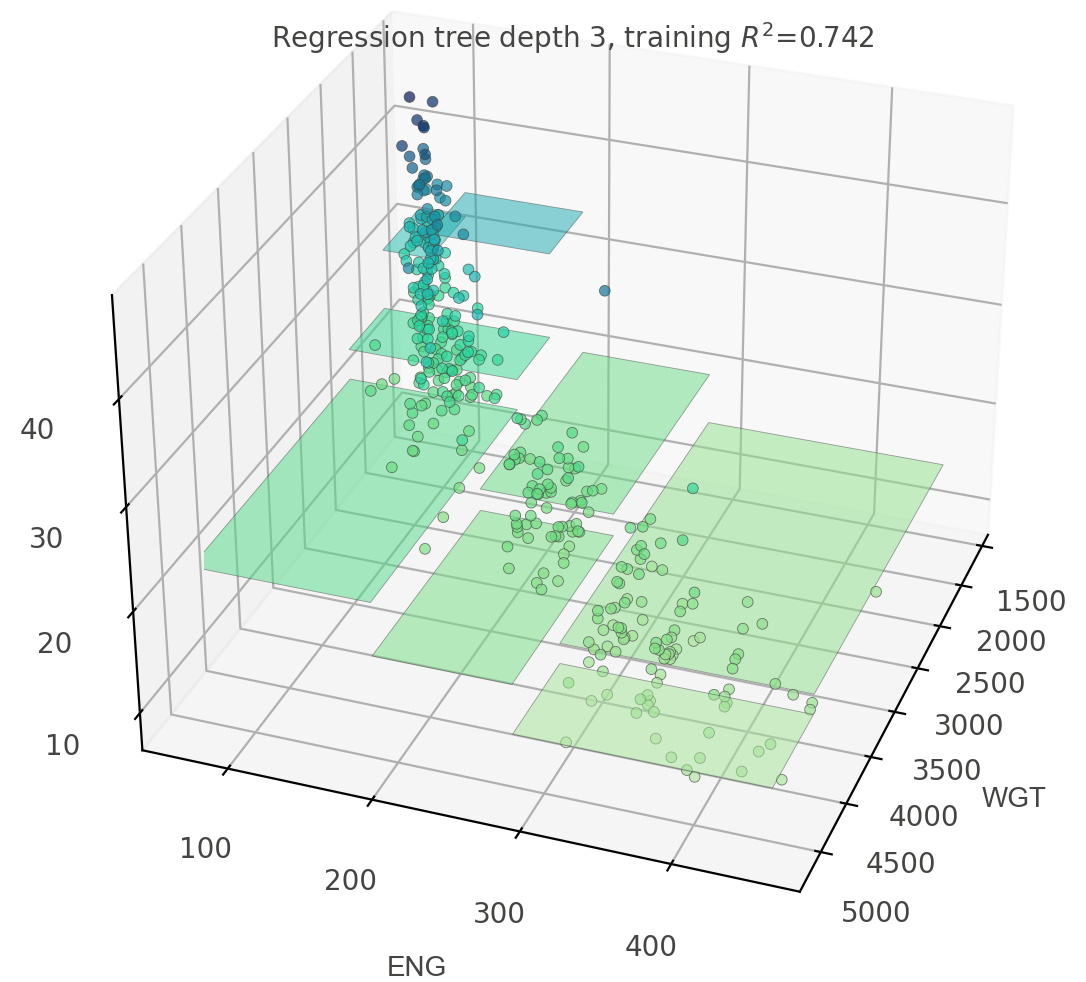

In [48]:
viz_rmodel.rtree_feature_space3D(fontsize=10,
                        elev=30, azim=20, 
                        show={'splits','title'},
                        colors={'tesselation_alpha':.5})

Equivalently, we can show a heat map as if we were looking at the three-dimensional plot from the top down:

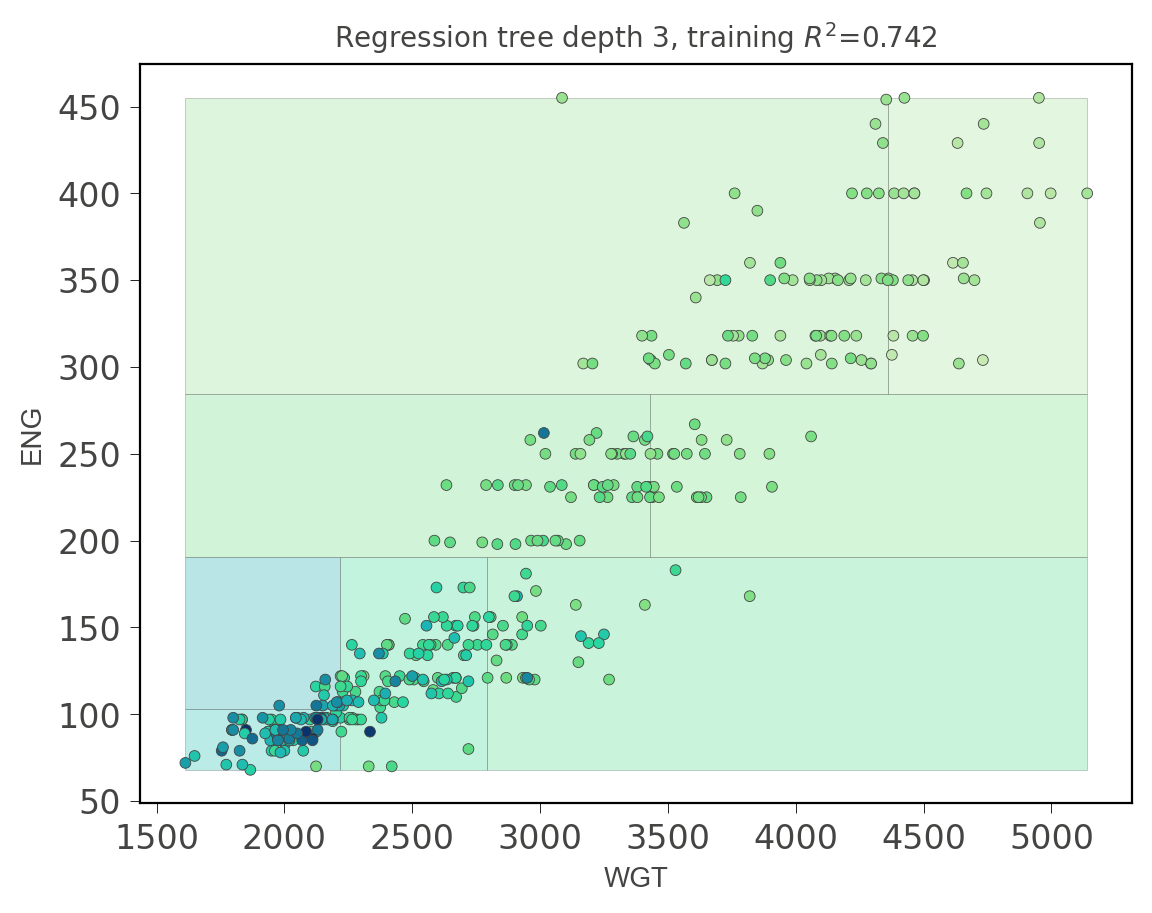

In [49]:
viz_rmodel.rtree_feature_space()